In [14]:
#Imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table, join
import illustris_python as il
from astropy.table import setdiff
import time as time
import scipy.signal as signal
import scipy.interpolate as interpolate
from astropy.cosmology import Planck15 as cosmo

In [15]:
"""
100-1 Loading
"""
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-100-1/output'
snapshot_ind = 99

"""
100-3 Loading
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-100-3/ouput'
snapshot_ind = 99 
"""

#Header gives basic group info
header = il.groupcat.loadHeader(basePath, snapshot_ind)
scale_factor = header['Time']

#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)

#Get the keys for each
subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

print(subhalo_grp['count'])
print(halo_grp['count'])

useless_keys_subhalo = ['count', 'SubhaloBHMdot','SubhaloBfldDisk','SubhaloBfldHalo','SubhaloGasMetalFractionsHalfRad',
                'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad',
                'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted',
               'SubhaloGasMetallicityMaxRad','SubhaloGasMetallicitySfr','SubhaloGasMetallicitySfrWeighted', 
               'SubhaloIDMostbound', 'SubhaloSFRinHalfRad','SubhaloSFRinMaxRad', 'SubhaloSFRinRad',
               'SubhaloStarMetalFractionsHalfRad','SubhaloStarMetalFractionsMaxRad']

for i in range(0, len(useless_keys_subhalo)):
    subhalo_keys.remove(useless_keys_subhalo[i])

[subhalo_grp.pop(key) for key in useless_keys_subhalo] 

useless_keys_halo = ['count','GroupBHMdot','GroupGasMetalFractions', 'GroupStarMetalFractions']
    
for i in range(0, len(useless_keys_halo)):
    halo_keys.remove(useless_keys_halo[i])

[halo_grp.pop(key) for key in useless_keys_halo] 

subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

subhalo_table = Table(list(subhalo_grp.values()), names=(subhalo_keys))
subhalo_table.add_column([x for x in range(len(subhalo_table))], name='Index' ,index=0)

halo_table = Table(list(halo_grp.values()), names=(halo_keys))
halo_table.add_column([x for x in range(len(halo_table))], name='SubhaloGrNr' ,index=0)

subhalo_table = join(subhalo_table, halo_table, keys='SubhaloGrNr', join_type='left')

subhalo_table.add_column(subhalo_table["SubhaloMassInHalfRadType"][:,4], name=str("StellarMassHalfRad"))
subhalo_table.add_column(subhalo_table["SubhaloMassType"][:,4], name=str("StellarMass"))
subhalo_table.add_column(subhalo_table['GroupFirstSub'] == subhalo_table['Index'],name=str("IsCentral"))
print(len(subhalo_table))

4371211
6291349
4371211


In [16]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

def cut_color_squares(table, min_gmr, max_gmr, min_rmz, max_rmz):
    #0.46, 0.34 min_gmr and max_rmz for my original "blue"
    #0.66, 0.52 min_gmr and min_rmz for my original "red"
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    rmz_cut_low = (mag[:,5]-mag[:,7])> min_rmz
    rmz_cut_high = (mag[:,5]-mag[:,7]) < max_rmz
    return table[gmr_cut_low & gmr_cut_high & rmz_cut_low & rmz_cut_high]

def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass < num
        return table[mask]

In [17]:
print(len(subhalo_table))
subhalo_table = subhalo_table[subhalo_table['SubhaloFlag']]
subhalo_table = subhalo_table[subhalo_table['SubhaloMassType'][:,4]!=0]
print(len(subhalo_table))

all_galaxies = cut_mass_high(subhalo_table, "GroupMass", 13)
all_galaxies = cut_mass_high(all_galaxies, "SubhaloMass", 9)

print(len(all_galaxies))
print('Masking step 1 - remove low-mass subhalos - complete \n')

centrals = all_galaxies[all_galaxies['IsCentral']]
satellites = all_galaxies[np.bitwise_not(all_galaxies['IsCentral'])]

field_galaxies = centrals[centrals['GroupNsubs']<=1]
field_galaxies = field_galaxies[field_galaxies['IsCentral']]

halo_table = halo_table[[np.unique(all_galaxies['SubhaloGrNr'])]]

print("Central galaxies: " + str(len(centrals)))
print("Satellite galaxies: " + str(len(satellites)))
print("Field Galaxies: " + str(len(field_galaxies)))
print("Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete \n")

4371211
327324
42205
Masking step 1 - remove low-mass subhalos - complete 

Central galaxies: 183
Satellite galaxies: 42022
Field Galaxies: 0
Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete 



/home/mattbel/.local/lib/python3.8/site-packages/astropy/table/table.py:1145: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]


In [ ]:
t0 = time.time()
"""
Go through all halos and add those within a certain distance.
"""
#Examine only galaxies mass greater than 10^8
to_add = cut_mass_high(subhalo_table, "SubhaloMass", 9)
print(len(to_add))

to_add = setdiff(to_add, satellites, keys='Index')
print(len(to_add))

to_add = setdiff(to_add, centrals, keys='Index')
print(len(to_add))

#iterate through all central galaxies
for i in range(0, len(centrals)):
    
    #get center of mass location for current central
    gal_cm = centrals['SubhaloPos'][i]
    
    #radius in Mpc/h to cut at
    value =  centrals['Group_R_Mean200'][i]*5*0.001
    
    #Get basic info about the box bounds to prevent wrapping issues.
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)

    #Create an array of distances from all subhalos in the data satisfying a certain criterion to gal_cm
    dev = to_add['SubhaloPos'] - gal_cm
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q  
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    
    #Cut here
    to_add_now = to_add[r_subhalo < value]
    
    if(len(to_add_now)!=0):
        to_add_now['IsCentral']==False
        to_add_now['SubhaloGrNr'] = np.ones(len(to_add_now))*centrals['SubhaloGrNr'][i]
        for k in range(0,len(halo_keys)):
            to_add_now[halo_keys[k]] = [centrals[halo_keys[k]][i]]*len(to_add_now)
        
        for j in range(0, len(to_add_now)):
            satellites.add_row(to_add_now[j])
            to_add = to_add[to_add['Index']!=to_add_now['Index'][j]]
            
    if(len(to_add)==0):
        break
        
        
print(time.time()-t0)

269521
227499
227316


In [6]:
from astropy.table import vstack
all_galaxies = vstack(([satellites, centrals]))

In [7]:
"""
Define color splits as per Tara's slide 24
"""
centrals_red = cut_mass_high(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_green = cut_mass_low(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_blue = cut_color_lines(centrals, 0, 0.5)

satellites_red = cut_mass_high(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, 0, 0.5)

field_galaxies_red = cut_mass_high(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_green = cut_mass_low(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_blue = cut_color_lines(field_galaxies, 0, 0.5)

print("Central galaxies red: " + str(len(centrals_red)))
print("Central galaxies green: " + str(len(centrals_green)))
print("Central galaxies blue: " + str(len(centrals_blue)))

print("Satellite galaxies red: " + str(len(satellites_red)))
print("Satellite galaxies green: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))

print("Field Galaxies red: " + str(len(field_galaxies_red)))
print("Field Galaxies green: " + str(len(field_galaxies_green)))
print("Field Galaxies blue: " + str(len(field_galaxies_blue)))

print("Masking step 3 - color splits for each type of galaxy, complete \n")

Central galaxies red: 53
Central galaxies green: 0
Central galaxies blue: 4
Satellite galaxies red: 1166
Satellite galaxies green: 8005
Satellite galaxies blue: 6448
Field Galaxies red: 0
Field Galaxies green: 0
Field Galaxies blue: 0
Masking step 3 - color splits for each type of galaxy, complete 



In [8]:
print(len(all_galaxies))

17167


# TESTING FOR DYNAMICAL FRICTION:

Number of halos with mass > 10^13 Msun:  60


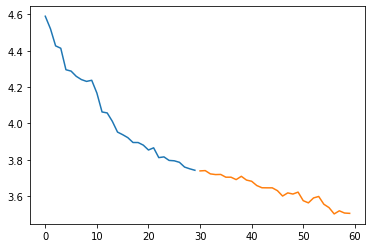

In [9]:
print("Number of halos with mass > 10^13 Msun: ", len(np.unique(all_galaxies['SubhaloGrNr'])))
halo_table1=halo_table[:int(len(halo_table)/2)]
halo_table2=halo_table[int(len(halo_table)/2):]
plt.plot(halo_table1['SubhaloGrNr'],np.log10(halo_table1['GroupMass']))
plt.plot(halo_table2['SubhaloGrNr'],np.log10(halo_table2['GroupMass']))

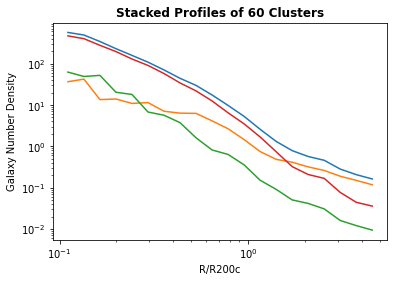

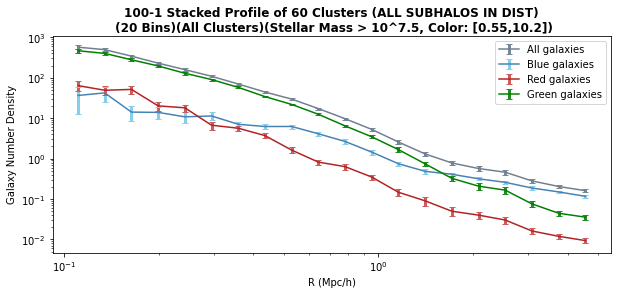

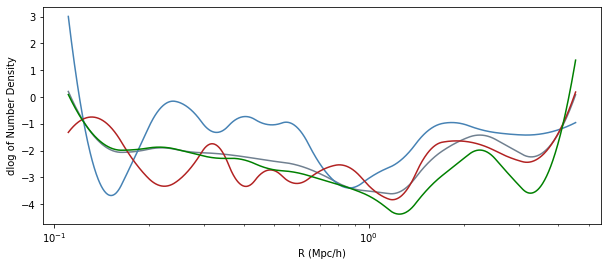

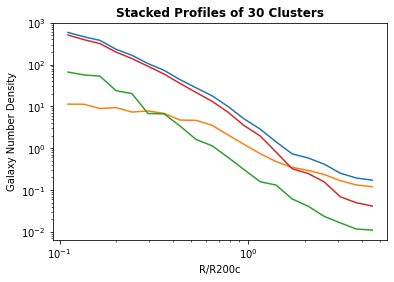

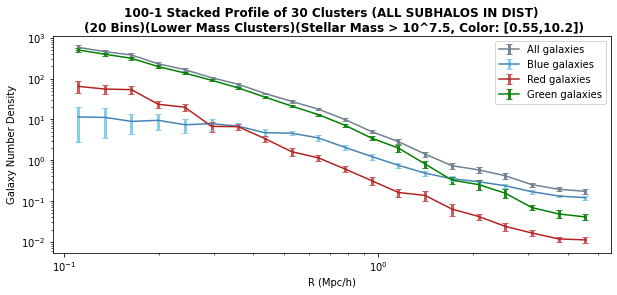

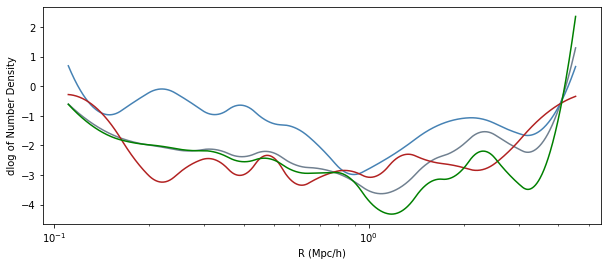

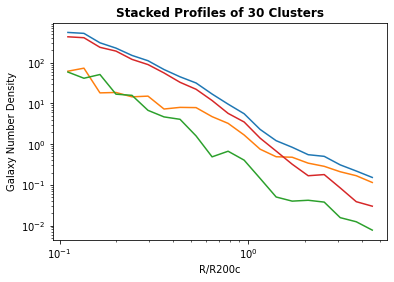

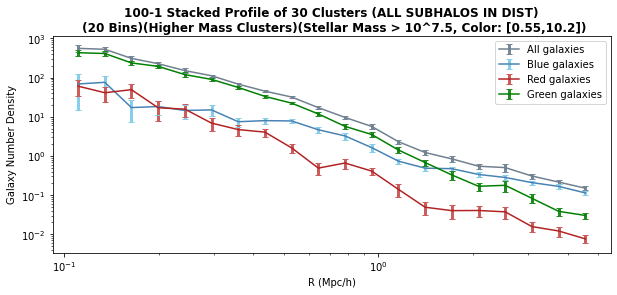

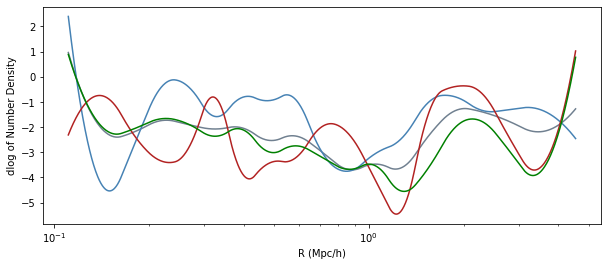

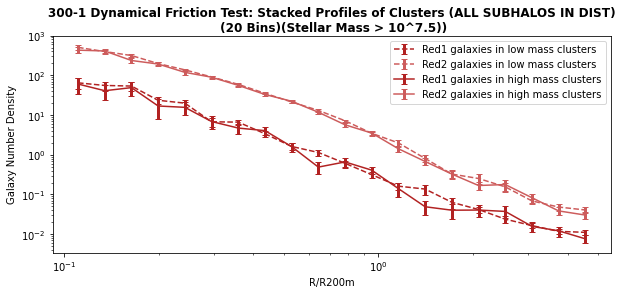

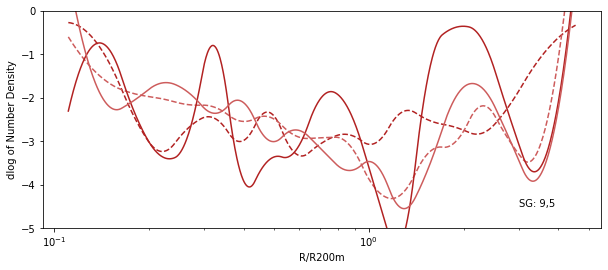

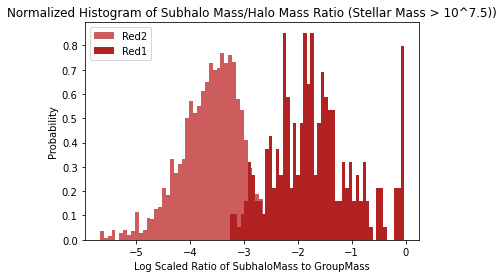

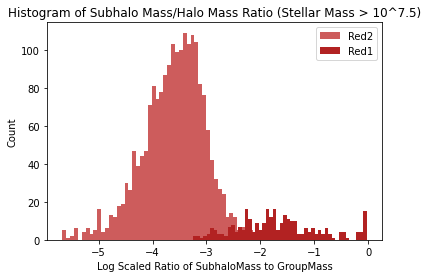

In [13]:
w,p = 9,5
bins = 20 

bin_stack, Yi_avg_red, Yi_avg_green, dlog_data_SG_x_r, dlog_data_SG_x_g, dlog_data_SG_y_r, dlog_data_SG_y_g, red1_ratio, red2_ratio, boot_err_red, boot_err_green = profile(halo_table, all_galaxies, True, False, "All Clusters", w, p, bins)

bin_stack11, Yi_avg_red11, Yi_avg_green11, dlog_data_SG_x_r1, dlog_data_SG_x_g1, dlog_data_SG_y_r1, dlog_data_SG_y_g1, red1_ratio1, red2_ratio1, boot_err_red1, boot_err_green1 = profile(halo_table1, all_galaxies, True, False, "Lower Mass Clusters", w, p, bins)

bin_stack12, Yi_avg_red12, Yi_avg_green12, dlog_data_SG_x_r2, dlog_data_SG_x_g2, dlog_data_SG_y_r2, dlog_data_SG_y_g2, red1_ratio2, red2_ratio2, boot_err_red2, boot_err_green2 = profile(halo_table2, all_galaxies, True, False, "Higher Mass Clusters", w, p, bins)


# PLOTTING ALL
# PLOTTING BOOTSTRAPPED STACKED PROFILES
plt.figure(figsize=(10,4))
plt.errorbar(bin_stack11, Yi_avg_red11, yerr = boot_err_red1, c='firebrick', ecolor = 'firebrick', elinewidth = 3, capsize=3, label = 'Red1 galaxies in low mass clusters', ls='--')
plt.errorbar(bin_stack11, Yi_avg_green11, yerr = boot_err_green1, c='indianred', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red2 galaxies in low mass clusters', ls='--')
plt.errorbar(bin_stack12, Yi_avg_red12, yerr = boot_err_red2, c='firebrick', ecolor = 'firebrick', elinewidth = 3, capsize=3, label = 'Red1 galaxies in high mass clusters')
plt.errorbar(bin_stack12, Yi_avg_green12, yerr = boot_err_green2, c='indianred', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red2 galaxies in high mass clusters')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R/R200m')
plt.ylabel('Galaxy Number Density')# (scaled by M200m)
plt.title('300-1 Dynamical Friction Test: Stacked Profiles of Clusters (ALL SUBHALOS IN DIST)\n (%s Bins)(Stellar Mass > 10^%s))' %(bins, 7.5), fontweight = 'bold', wrap=True)
plt.legend()

# SG LOG DERIVATIVE AND PLOT
plt.figure(figsize = (10,4))
plt.plot(dlog_data_SG_x_r1, dlog_data_SG_y_r1, c = 'firebrick', ls='--')
plt.plot(dlog_data_SG_x_g1, dlog_data_SG_y_g1, c = 'indianred',ls='--')
plt.plot(dlog_data_SG_x_r2, dlog_data_SG_y_r2, c = 'firebrick')
plt.plot(dlog_data_SG_x_g2, dlog_data_SG_y_g2, c = 'indianred')
plt.xscale('log')
plt.xlabel('R/R200m')
plt.ylabel('dlog of Number Density')
plt.text(3,-4.5,'SG: %s,%s'%(w,p))
plt.ylim(-5,0)


# Dynamical Friction Histograms
plt.figure()
plt.hist(np.log10(red2_ratio2), bins=50, label = 'Red2', density=True, stacked=True, color='indianred')
plt.hist(np.log10(red1_ratio2), bins=50, label = 'Red1',density=True,stacked=True,color='firebrick')
plt.xlabel('Log Scaled Ratio of SubhaloMass to GroupMass')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Subhalo Mass/Halo Mass Ratio (Stellar Mass > 10^%s))' %(7.5))
plt.legend()

plt.figure()
plt.hist(np.log10(red2_ratio2), bins=50, label = 'Red2', density=False, stacked=True, color = 'indianred')
plt.hist(np.log10(red1_ratio2), bins=50, label = 'Red1',density=False,stacked=True, color='firebrick')
plt.xlabel('Log Scaled Ratio of SubhaloMass to GroupMass')
plt.ylabel('Count')
plt.title('Histogram of Subhalo Mass/Halo Mass Ratio (Stellar Mass > 10^%s)' %(7.5))
plt.legend()

In [11]:
'''
h_table - halo_table
sh_table - subhalo_table
appended - were additional subhalos outside a certain radius added to halos?
to_print - whether or not to print halo data
returns - Rscale?
cluster_type - string used in title name
'''
def profile(h_table, sh_table, appended, to_print, cluster_type, w, p, bins):
    t0 = time.time()
    Rmin = 0.1
    Rmax, Halo_Rmax = 5, 5  #5.5 # for R200c  #7
    redshift = header['Redshift']
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac

    NDensity_list = []
    NDensity_list_b = []
    NDensity_list_r = []
    NDensity_list_g = []
    RScale_list = []
    red1_ratio = []
    red2_ratio = []
    
    for i in range(0,len(h_table)):
        relevant_subhalos = sh_table[sh_table['SubhaloGrNr'] == h_table['SubhaloGrNr'][i]]
        #print(len(relevant_subhalos))
        if(to_print):
            print("\nHalo index:", i)
            print("Halo Mass:", h_table['GroupMass'][i])
            if(appended):
                N_subhalos = len(relevant_subhalos)
                print("N Subhalos from Illustris + Appending:", N_subhalos)
            else:
                N_subhalos = h_table['GroupNsubs'][i]
                print("N Subhalos from Illustris Algorithm:", N_subhalos)
                
            # TAKING TABLE WITH CLEAN SUBS AFTER MASS CUT AND GETTING FOR DISTANCE
            R500c = 0.001*scale_factor*h_table['Group_R_Crit500'][i] #ckpc/h to Mpc/h
            R200c = 0.001*scale_factor*h_table['Group_R_Crit200'][i]
            R200m = 0.001*scale_factor*h_table['Group_R_Mean200'][i]
            print("R500c, R200c, R200m:",R500c, R200c, R200m)

        RScale = 0.001*scale_factor*h_table['Group_R_Mean200'][i]
        RScale_list.append(RScale)
        dev = np.array(relevant_subhalos['SubhaloPos']-h_table['GroupPos'][i]) #has all subhalos > mass cut
        
        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
        r_subhalo_all = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h #has all subhalos > mass cut
        
        if(to_print):
            print(len(CM_coords),len(r_subhalo_all), 'time', time.time()-t0)
            
        # TAKING SUBS IN DISTANCE OF HALO CENTER
        relevant_subhalos = relevant_subhalos[r_subhalo_all<=(Halo_Rmax*RScale)]
        
        if(to_print):
            print("N Subhalos within %s*R200m:" %(Halo_Rmax), len(subhalo_table_hi))

        # COLOR CUTS
        gmr = relevant_subhalos['SubhaloStellarPhotometrics'][:,4]-relevant_subhalos['SubhaloStellarPhotometrics'][:,5]
        sm = np.log10(relevant_subhalos['StellarMass']*1e10)
        b1,b2 = -0.2, 0.5
        r1, r2 = 0.55, 1.0
        sm1 = 10.2
        blue_mask_subs = (gmr<0.55)
        red_mask_subs = (gmr>r1)&(sm>=sm1)
        green_mask_subs = (gmr>r1)&(sm<sm1)
        color_title = '[%s,%s]' %(r1,sm1)

        red1_ratio.extend(((relevant_subhalos['SubhaloMass'][red_mask_subs])/(h_table['GroupMass'][i])).tolist())
        red2_ratio.extend(((relevant_subhalos['SubhaloMass'][green_mask_subs])/(h_table['GroupMass'][i])).tolist())

        NDensity, NDensity_blue, NDensity_red, NDensity_green, galaxies, galaxies_blue, galaxies_red, galaxies_green= DensityProfileColors(
            RScale, Rmin,Rmax,bins,r_subhalo_all,blue_mask_subs, red_mask_subs,green_mask_subs)    

        if(to_print):
            print("galaxies", galaxies)
            print("blue galaxies counted", galaxies_blue)
            print("red galaxies counted", galaxies_red)
            print("red galaxies counted", galaxies_green)

        NDensity_list.append(NDensity) #/M200m
        NDensity_list_b.append(NDensity_blue)
        NDensity_list_r.append(NDensity_red)
        NDensity_list_g.append(NDensity_green)
        

    # RADIAL BINS, R_AVG, ETC
    R_avg = np.mean(RScale_list) #Mpc/h
    if(to_print):
        print("R_avg:", R_avg)

    bin_divided = np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1)
    bin_stack = (bin_divided[1:]+bin_divided[:-1])/2

    # PLOTTING BASIC AVERAGED STACKS
    NDensity_stack = np.mean(NDensity_list, axis=0)
    NDensity_stack_b = np.mean(NDensity_list_b, axis=0)
    NDensity_stack_r = np.mean(NDensity_list_r, axis=0)
    NDensity_stack_g = np.mean(NDensity_list_g, axis=0)
    plt.figure()
    plt.plot(bin_stack, NDensity_stack, '-')
    plt.plot(bin_stack, NDensity_stack_b, '-')
    plt.plot(bin_stack, NDensity_stack_r, '-')
    plt.plot(bin_stack, NDensity_stack_g, '-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R/R200c')
    plt.ylabel('Galaxy Number Density')
    plt.title('Stacked Profiles of %s Clusters' %(len(h_table)), fontweight = 'bold', wrap=True)
    plt.show()

    # BOOTSTRAP PROFILES, ERRORBARS
    Yi_avg, cov, boot_err = Bootstrap_Covariance(NDensity_list, 300, bins)
    Yi_avg_blue, cov_blue, boot_err_blue = Bootstrap_Covariance(NDensity_list_b, 300, bins)
    Yi_avg_red, cov_red, boot_err_red = Bootstrap_Covariance(NDensity_list_r, 300, bins)
    Yi_avg_green, cov_green, boot_err_green = Bootstrap_Covariance(NDensity_list_g, 300, bins)
    dlog_data_SG_x, dlog_data_SG_y, yy_fine, xx_fine = get_slope_sg(bin_stack, (Yi_avg), 1000,w,p)  
    dlog_data_SG_x_b, dlog_data_SG_y_b, yy_fine_b, xx_fine_b = get_slope_sg(bin_stack, (Yi_avg_blue), 1000,w,p)  
    dlog_data_SG_x_r, dlog_data_SG_y_r, yy_fine_r, xx_fine_r = get_slope_sg(bin_stack, (Yi_avg_red), 1000,w,p)  
    dlog_data_SG_x_g, dlog_data_SG_y_g, yy_fine_g, xx_fine_g = get_slope_sg(bin_stack, (Yi_avg_green), 1000,w,p)  
      
    # PLOTTING BOOTSTRAPPED STACKED PROFILES
    plt.figure(figsize=(10,4))
    plt.errorbar(bin_stack, Yi_avg, yerr = boot_err, c = 'slategrey', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
    plt.errorbar(bin_stack, Yi_avg_blue, yerr = boot_err_blue, c = 'steelblue',ecolor = 'skyblue', elinewidth = 3, capsize=3, label = 'Blue galaxies')
    plt.errorbar(bin_stack, Yi_avg_red, yerr = boot_err_red, c='firebrick', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red galaxies')
    plt.errorbar(bin_stack, Yi_avg_green, yerr = boot_err_green, c='green', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Green galaxies')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R (Mpc/h)')
    plt.ylabel('Galaxy Number Density')# (scaled by M200m)
    plt.title('100-1 Stacked Profile of %s Clusters (ALL SUBHALOS IN DIST)\n (%s Bins)(%s)(Stellar Mass > 10^%s, Color: %s)' 
              %(len(h_table), bins, cluster_type ,7.5, color_title), fontweight = 'bold', wrap=True)
    plt.legend()
    plt.show()

    # SG LOG DERIVATIVE AND PLOT
    plt.figure(figsize = (10,4))
    plt.plot(dlog_data_SG_x, dlog_data_SG_y, c = 'slategrey')
    plt.plot(dlog_data_SG_x_b, dlog_data_SG_y_b, c = 'steelblue')
    plt.plot(dlog_data_SG_x_r, dlog_data_SG_y_r, c = 'firebrick')
    plt.plot(dlog_data_SG_x_g, dlog_data_SG_y_g, c = 'green')
    plt.xscale('log')
    plt.xlabel('R (Mpc/h)')
    plt.ylabel('dlog of Number Density')
    plt.show()

    return bin_stack, Yi_avg_red, Yi_avg_green, dlog_data_SG_x_r, dlog_data_SG_x_g, dlog_data_SG_y_r, dlog_data_SG_y_g, red1_ratio, red2_ratio, boot_err_red, boot_err_green

# Profile Fitting

In [12]:
import astropy.stats as astats
def Bootstrap_Covariance(NDensity_list, Nb, R):
    halo_array2 = np.arange(0,len(NDensity_list))
    halo_boot = astats.bootstrap(halo_array2, bootnum=300, samples=None)
    resampled_list = []
    for b in range(0,300):
        mask_b = (np.array(halo_boot[b].astype(int)))
        resampled_profile = np.mean((np.array(NDensity_list))[mask_b], axis=0)
        resampled_list.append(resampled_profile)
    resampled_array = np.array(resampled_list)
    Yi = resampled_array
    Yi_avg = np.mean(Yi, axis=0)
    Yi_avg_array = np.tile(Yi_avg, (Nb,1))
    minus_array = Yi - Yi_avg_array
    Yi_cov = np.zeros((R,R))
    for i in range(R):
        for j in range(R):
            Yi_cov[i,j] = (1./(Nb-1.))*(np.sum(minus_array[:,i]*minus_array[:,j]))
    boot_err = np.sqrt(np.diag(Yi_cov))
    return Yi_avg, Yi_cov, boot_err

#SAVITSKY GOLAY LOG DERIVATIVE:
#Functions to get log slope\
#w = 7
#p = 5
def get_slope_sg(xx, yy, num_output, w, p):
    # Savitsky-Golay smoothing
    window_size = w
    poly_order = p
    yy_filtered = signal.savgol_filter(np.log(yy), window_size, poly_order)
    # fit spline
    yy_spline = interpolate.interp1d(np.log(xx), yy_filtered, kind = 'cubic')
    #Evaluate spline on very fine grid
    numsmooth = 1000
    lnxx_fine = np.linspace(np.log(np.min(xx)), np.log(np.max(xx)), num = numsmooth)
    lnyy_fine = yy_spline(lnxx_fine)
    yy_fine = np.exp(lnyy_fine)
    #Calculate derivative using finite differences
    dlny_dlnx_fine = (lnyy_fine[1:] - lnyy_fine[:-1])/(lnxx_fine[1:] - lnxx_fine[:-1])
    #Interpolate derivative onto desired array
    interp_func = interpolate.interp1d(lnxx_fine[:-1], dlny_dlnx_fine)
    lnxx_out = np.linspace(np.min(lnxx_fine[:-1]), np.max(lnxx_fine[:-1]), num = num_output)
    dlny_dlnx_out = interp_func(lnxx_out)
    return np.exp(lnxx_out), dlny_dlnx_out, yy_fine, np.exp(lnxx_fine)

def DensityProfileColors(RScale, Rmin,Rmax,bins,r_subhalo,blue_mask_subs,red_mask_subs,green_mask_subs):    
    # MAKING PROFILE
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1) #3.5 earlier
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    NDensity = []
    NDensity_blue = []
    NDensity_red = []
    NDensity_green = []
    galaxies = []
    galaxies_blue = []
    galaxies_red = []
    galaxies_green = []
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        r_masked = r_subhalo[mask_sep]
        number = len(r_masked)
        delta_r = bin_max[i] - bin_min[i]
        volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3))
        density = number/volume
        r = (bin_min[i] + bin_max[i])/2
        galaxies.append(number)
        NDensity.append(density)
        number_blue=0
        number_red=0
        number_green=0
        if(len(blue_mask_subs) != 0):
            number_blue = len(r_subhalo[mask_sep & blue_mask_subs])
        if(len(red_mask_subs) != 0):    
            number_red = len(r_subhalo[mask_sep & red_mask_subs])
        if(len(green_mask_subs) != 0): 
            number_green = len(r_subhalo[mask_sep & green_mask_subs])

        NDensity_blue.append(number_blue/volume)
        NDensity_red.append(number_red/volume)
        NDensity_green.append(number_green/volume)        
        galaxies_blue.append(number_blue)
        galaxies_red.append(number_red)
        galaxies_green.append(number_green)
    return NDensity, NDensity_blue, NDensity_red, NDensity_green, galaxies, galaxies_blue, galaxies_red, galaxies_green

In [ ]:
# REPLOTTING AND ADJUSTING (NEW ALL SUBS/TABLE)

#SAVITSKY GOLAY LOG DERIVATIVE:
#Functions to get log slope
import scipy.signal as signal
import scipy.interpolate as interpolate
w = 9#9
p = 5#5
def get_slope_sg(xx, yy, num_output):
    # Savitsky-Golay smoothing                                                                                                                                        
    window_size = w#7#9
    poly_order = p#5#5
    yy_filtered = signal.savgol_filter(np.log(yy), window_size, poly_order)
    # fit spline                                                                                                                                                      
    yy_spline = interpolate.interp1d(np.log(xx), yy_filtered, kind = 'cubic')
    #Evaluate spline on very fine grid                                                                                                                                
    numsmooth = 1000
    lnxx_fine = np.linspace(np.log(np.min(xx)), np.log(np.max(xx)), num = numsmooth)
    lnyy_fine = yy_spline(lnxx_fine)
    yy_fine = np.exp(lnyy_fine)
    #Calculate derivative using finite differences                                                                                                                    
    dlny_dlnx_fine = (lnyy_fine[1:] - lnyy_fine[:-1])/(lnxx_fine[1:] - lnxx_fine[:-1])
    #Interpolate derivative onto desired array                                                                                                                        
    interp_func = interpolate.interp1d(lnxx_fine[:-1], dlny_dlnx_fine)
    lnxx_out = np.linspace(np.min(lnxx_fine[:-1]), np.max(lnxx_fine[:-1]), num = num_output)
    dlny_dlnx_out = interp_func(lnxx_out)
    return np.exp(lnxx_out), dlny_dlnx_out, yy_fine, np.exp(lnxx_fine)
# BOOTSTRAP PROFILES, ERRORBARS
Yi_avg1, cov1, boot_err1 = Bootstrap_Covariance(NDensity_list, 300, bins)
Yi_avg_blue1, cov_blue1, boot_err_blue1 = Bootstrap_Covariance(NDensity_list_b, 300, bins)
Yi_avg_red1, cov_red1, boot_err_red1 = Bootstrap_Covariance(NDensity_list_r, 300, bins)
Yi_avg_green1, cov_green1, boot_err_green1 = Bootstrap_Covariance(NDensity_list_g, 300, bins)

dlog_data_SG_x, dlog_data_SG_y, yy_fine, xx_fine = get_slope_sg(bin_stack1, (Yi_avg1), 1000)  
dlog_data_SG_x_b, dlog_data_SG_y_b, yy_fine_b, xx_fine_b = get_slope_sg(bin_stack1, (Yi_avg_blue1), 1000)  
dlog_data_SG_x_r, dlog_data_SG_y_r, yy_fine_r, xx_fine_r = get_slope_sg(bin_stack1, (Yi_avg_red1), 1000)  
dlog_data_SG_x_g, dlog_data_SG_y_g, yy_fine_g, xx_fine_g = get_slope_sg(bin_stack1, (Yi_avg_green1), 1000)  

        
# PLOTTING BOOTSTRAPPED STACKED PROFILES
plt.figure(figsize=(10,4))
plt.errorbar(bin_stack1, Yi_avg1, yerr = boot_err1, c = 'slategrey', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
plt.errorbar(bin_stack1, Yi_avg_blue1, yerr = boot_err_blue1, c = 'steelblue',ecolor = 'skyblue', elinewidth = 3, capsize=3, label = 'Blue galaxies')
plt.errorbar(bin_stack1, Yi_avg_red1, yerr = boot_err_red1, c='firebrick', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red galaxies')
plt.errorbar(bin_stack1, Yi_avg_green1, yerr = boot_err_green1, c='green', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Green galaxies')
#plt.plot(xx_fine, yy_fine, c = 'orange')
#plt.plot(xx_fine_b, yy_fine_b, c = 'orange')
#plt.plot(xx_fine_r, yy_fine_r, c = 'orange')
#plt.plot(xx_fine_g, yy_fine_g, c = 'orange')

#plt.plot(xx_fine_g, yy_fine_g, c = 'orange')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc/h)')
plt.ylabel('Galaxy Number Density')# (scaled by M200m)
plt.title('300-1 Stacked Profile of %s Clusters (ALL SUBHALOS IN %s*R200m)\n (%s Bins)(Cluster > 5*10^13)(Stellar Mass > 10^%s, Color: %s)' %(Number_of_halos, Halo_Rmax, bins, M,color_title), fontweight = 'bold', wrap=True)
plt.legend()

# SG LOG DERIVATIVE AND PLOT
plt.figure(figsize = (10,4))
plt.plot(dlog_data_SG_x, dlog_data_SG_y, c = 'slategrey')
plt.plot(dlog_data_SG_x_b, dlog_data_SG_y_b, c = 'steelblue')
plt.plot(dlog_data_SG_x_r, dlog_data_SG_y_r, c = 'firebrick')
plt.plot(dlog_data_SG_x_g, dlog_data_SG_y_g, c = 'green')
plt.xscale('log')
plt.xlabel('R (Mpc/h)')
plt.ylabel('dlog of Number Density')
plt.text(2.8,-4.5,'SG: %s,%s'%(w,p))
plt.ylim(-5,0)
plt.show()

# Color and Phase Space Plots

In [ ]:
def plot_all_bands(table):
    subhalomass = np.array(np.log10(table["SubhaloMassInHalfRad"]*1e10))
    mask = subhalomass > 10.3
    st = table[mask]
    fig, ax = plt.subplots(4,2)
    fig.set_size_inches(16,20)
    plt.subplots_adjust(hspace = 0.5)
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    for bands in range(8):
        mag = st['SubhaloStellarPhotometrics'][:,bands]
        ax[bands%4][bands//4].hist(mag, bins=50)
        ax[bands%4][bands//4].set_xlabel('magnitude in ' + band_names[bands] + " band", fontsize = 16 )
        ax[bands%4][bands//4].set_ylabel('count', fontsize = 16)
    plt.show()

In [ ]:
def mass_vs_gmr(table, table_name, mass_type):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    mass = np.array(np.log10(table[mass_type]*1e10))
    plt.ylabel("$\mathrm{g-r}$", fontsize = 16)
    plt.xlabel("Mass", fontsize = 16)
    plt.title(table_name, fontsize = 16)
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, mag, bins=50, cmap='viridis', cmin=0.1) #, range=[[9,12], [0,1]])
    plt.show()

In [ ]:
def formation_rate_vs_gmr(table, table_name):
    #table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    mass = table['SubhaloSFR']
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    plt.hist2d(mag, mass, bins=50, cmap='viridis', cmin=0.1) # range=[[0,0.9], [0,0.8]])
    plt.colorbar()
    plt.show()

In [ ]:
def metallicity_vs_gmr(table, table_name):
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    metallicity = table['SubhaloStarMetallicity']
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Mass-weighted average metallicity", fontsize = 14)
    plt.title(table_name, fontsize=16)
    plt.hist2d(mag, metallicity, bins=50, cmap='viridis', range=[[0,0.9], [0,0.08]], cmin=0.1)
    plt.colorbar()
    plt.show()

In [ ]:
def formation_rate_vs_mass(table, table_name, mass_type):
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    #table = table[mag<0.55] #mag cut 
    mass = np.array(np.log10(table[mass_type]*1e10))
    plt.figure(figsize=(8,6))
    sfr = table['SubhaloSFR']
    plt.xlabel("Mass", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    plt.hist2d(mass, sfr, bins=50, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,10]])
    plt.colorbar()
    plt.show()

In [ ]:
def hydrogen_rate_vs_gmr(table, table_name):
    table = table[table['SubhaloStarMetalFractions'][:,0]>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Hydrogen Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,0], bins=50, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [ ]:
def helium_rate_vs_gmr(table, table_name):
    table = table[table['SubhaloStarMetalFractions'][:,1]>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Helium Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,1], bins=50, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [ ]:
def element_rate_vs_mass(table, table_name, mass_type):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    fig, ax = plt.subplots(3,3)
    fig.set_size_inches(16,16)
    for i in range (0, len(elements)):
        mass = np.array(np.log10(table[mass_type]*1e10))
        ax[i//3][i%3].set_xlabel("Mass: " + str(mass_type), fontsize = 11)
        ax[i//3][i%3].set_ylabel(elements[i] + " Abundance", fontsize = 11)
        ax[i//3][i%3].set_title(elements[i] + " in " + table_name, fontsize=12)
        ax[i//3][i%3].hist2d(mass, table['SubhaloStarMetalFractions'][:,i], bins=50, cmap='viridis', cmin=0.1)

In [ ]:
def element_rate_vs_gmr(table, table_name):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    for i in range (0, len(elements)):
        #table = table[table['SubhaloStarMetalFractions']>0]
        mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
        plt.figure(figsize=(6,4))
        plt.xlabel("$\mathrm{g-r}$", fontsize = 11)
        plt.ylabel(elements[i] + " Abundance", fontsize = 11)
        plt.title(elements[i] + " in " + table_name, fontsize=12)
        plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,i], bins=50, cmap='viridis', cmin=0.1) 
        plt.colorbar()
        plt.show()

In [ ]:
def gmr_mass_bins_hist(table, table_name, mass_type):
    bins = [9.0,9.5,10.0,10.5,11.0,11.5,12.0]
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(18,11)
    for i in range(0,6):
        s1 = cut_mass_high(table, mass_type, bins[i])
        s2 = cut_mass_low(table, mass_type, bins[i+1])
        mask2 = np.array(np.log10(s1[mass_type]*1e10)) < bins[i+1]
        s2 = s1[mask2]
        mag = s2['SubhaloStellarPhotometrics'][:,4] - s2['SubhaloStellarPhotometrics'][:,5]
        ax[i//3][i%3].hist(mag, bins=50) #, density=True)
        ax[i//3][i%3].set_title("Mass bin: "+str(bins[i])+"-"+str(bins[i+1]) + " for table: " + table_name)
        ax[i//3][i%3].set_xlabel('magnitude in g-r band', fontsize = 16 )
        ax[i//3][i%3].set_ylabel('count', fontsize = 16)

In [ ]:
def color_color(mag, r1, r2, table_name):
    g_minus_r = mag[:,4]-mag[:,5]
    r_minus_z = mag[:,5]-mag[:,7]
    plt.figure(figsize=(8,6))
    #heights, rmz,gmr = np.histogram2d(r_minus_z,g_minus_r,bins=150)
    plt.hist2d(g_minus_r,r_minus_z, bins = 50, cmap='viridis', range=[[r1, 1], [r2, 1]], cmin = 0.1)
    plt.xlabel("$\mathrm{g-r}$", fontsize = 20)
    plt.ylabel("$\mathrm{r-z}$", fontsize = 20)
    plt.title("Color-Color plot for " + table_name, fontsize = 20)
    plt.colorbar()
    plt.grid(b=True, which='both', axis='both')

In [ ]:
def color_density(mag, band1, band2, band3, title):
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    r = mag[:,band1]
    r_minus_z = mag[:,band2]-mag[:,band3]
    plt.figure(figsize=(8,6))
    plt.hist2d(r, r_minus_z, bins = 50, cmap='viridis', cmin=0.1)#, range=[[0, 0.7], [0, 0.8]])
    plt.ylabel(band_names[band2]+"-"+band_names[band3], fontsize = 20)
    plt.xlabel(band_names[band1], fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.colorbar()

In [ ]:
def galaxy_dist_vs_mass(table, table_name, color, mass_type, mass_show):
    
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    
    mass = np.array(np.log10(table[mass_type]*1e10))
    if(mass_show):
        plt.figure(figsize=(8,6))
        plt.hist2d(mass, r_subhalo, bins=50, cmap='viridis', cmin=0.1, range=[[9,12.5],[0,4]])
        plt.xlabel(mass_type)
        plt.ylabel("Distance in Mpc/h")
        plt.title("Distance of "  + color + " " + table_name + " from Halo Center vs. Mass.")
        plt.colorbar()
        plt.show()
    
    else:
        plt.hist(r_subhalo, bins=50)
        plt.title("Histogram of " + color + " " + table_name + " distance from Halo Center")
        plt.xlabel("Distance in Mpc/h")
        plt.show()

In [ ]:
def rotation_curve_vs_mass(table, table_name, color, mass_type):
    plt.figure(figsize=(8,6))
    mass = (np.log10(table[mass_type]*1e10))
    plt.hist2d(mass,table['SubhaloVmax'], bins=50, cmap='viridis', cmin=0.1, range=[[9,12.5],[0,800]])
    plt.title("Mass vs. max of rotation curve for " + color + " " + table_name)
    plt.ylabel("Max of spherically-averaged rotation curve. (km/s)", fontsize=14)
    plt.xlabel("Mass")
    plt.show()

In [ ]:
def peculiar_velocity_vs_mass(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    velocity = np.sqrt((v[:,0])**2 + (v[:,1])**2 +(v[:,2])**2)
    mass = np.array(np.log10(table[mass_type]*1e10))
    plt.figure(figsize=(8,6))
    plt.hist2d(mass,velocity, bins=50, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,3000]])
    plt.title("Mass vs. Peculiar velocity " + color + " " + table_name , fontsize=14)
    plt.ylabel("Peculiar velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel(mass_type, fontsize=14)
    plt.colorbar()
    plt.show()

In [ ]:
def phase_space(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    dev = dev/(np.linalg.norm(dev, axis=1).reshape(-1,1))
    v_rad = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        v_rad[i]= np.dot(v[i],dev[i])

    plt.figure(figsize=(8,6))
    plt.hist2d(r_subhalo,v_rad, bins=30, cmap='viridis', cmin=0.1)
    plt.title("Phase Space " + color + " " + table_name , fontsize=14)
    plt.ylabel("Radial velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()
    
def tangential_v1(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    dev = dev
    v_tan = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        cross_prod = np.cross(v[i],dev[i])
        norm_cross = np.linalg.norm(cross_prod)
        v_tan[i]= norm_cross/(np.linalg.norm(dev[i]))

    plt.figure(figsize=(8,6))
    plt.hist2d(r_subhalo,v_tan, bins=30, cmap='viridis', cmin=0.1)
    plt.title("Phase Space " + color + " " + table_name , fontsize=14)
    plt.ylabel("Tangential velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()

In [ ]:
def cent_acc_vs_rad(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc
    dev = np.linalg.norm(dev, axis=1)
    v_sq = (np.linalg.norm(v, axis=1))**2
    rad_acc = v_sq/dev
    plt.figure(figsize=(8,6))
    plt.hist2d(r_subhalo,rad_acc, bins=30, cmap='viridis', cmin=0.1, range=[[0,8],[0,2000]])
    plt.title("Phase Space " + color + " " + table_name , fontsize=14)
    plt.ylabel("Radial acceleration of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()

In [ ]:
arrs = [satellites_red, satellites_green, satellites_blue]
color = ['red', 'green', 'blue']
for i in range(0,3):
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = arrs[i]['SubhaloPos']-arrs[i]['GroupPos']

    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h

    mass = np.array(np.log10(arrs[i]["StellarMass"]*1e10))
    plt.hist(r_subhalo, bins=50, color=color[i], histtype='step')# , density=True), ('label1', 'label2', 'label3'))
    print("Mean distance of " + color[i] + " galaxies from halo center in Mpc/h: " + str(np.mean(r_subhalo)))
    print("Number of subhalos that are " + color[i] + ": " +str(len(r_subhalo)) + "\n")
    
plt.title("Histogram of satellite galaxy distance from Halo Center by color.")
plt.xlabel("Distance in Mpc/h")
plt.show()

In [ ]:
#plot_all_bands(all_galaxies)
color_color(all_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "All Galaxies")
testing = cut_mass_high(all_galaxies, "StellarMass", 9)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^9 M_sun")
testing = cut_mass_high(all_galaxies, "StellarMass", 10)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^10 M_sun")
testing = cut_mass_high(all_galaxies, "StellarMass",11)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^11 M_sun")

In [ ]:
mass_vs_gmr(all_galaxies, "All Galaxies", "StellarMass")
mass_vs_gmr(centrals, "Central Galaxies", "StellarMass")
mass_vs_gmr(satellites, "Satellites", "StellarMass")
mass_vs_gmr(field_galaxies, "Field", "StellarMass")

In [ ]:
gmr_mass_bins_hist(all_galaxies, "All Galaxies" ,"StellarMass")
gmr_mass_bins_hist(satellites, "Satellite Galaxy" ,"StellarMass")
gmr_mass_bins_hist(centrals, "Centrals" ,"StellarMass")

In [ ]:
color_density(all_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all galaxies")
color_density(satellites['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all satellites")
color_density(centrals['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for Centrals")
color_density(field_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for field galaxies")

In [ ]:
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9.5")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 10.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>10.5")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 11)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>11")

In [ ]:
formation_rate_vs_gmr(all_galaxies, "All Galaxies")
formation_rate_vs_gmr(satellites, "Satellites")
formation_rate_vs_gmr(centrals, "Central Galaxies")
formation_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 9.4)
formation_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^9.4")

In [ ]:
hydrogen_rate_vs_gmr(all_galaxies, "All Galaxies")
hydrogen_rate_vs_gmr(satellites, "Satellites")
hydrogen_rate_vs_gmr(centrals, "Central Galaxies")
hydrogen_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 10)
hydrogen_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^10")

In [ ]:
helium_rate_vs_gmr(all_galaxies, "All Galaxies")
helium_rate_vs_gmr(satellites, "Satellites")
helium_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
helium_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
mag = centrals_in_cluster['SubhaloStellarPhotometrics'][:,4] - centrals_in_cluster['SubhaloStellarPhotometrics'][:,5]
to_send = centrals_in_cluster[mag>0.55] 
element_rate_vs_mass(to_send, "Red Central Galaxies in Clusters", "StellarMass")
to_send = centrals_in_cluster[mag<0.55] 
element_rate_vs_mass(to_send, "Blue Central Galaxies in Clusters", "StellarMass")

In [ ]:
formation_rate_vs_mass(all_galaxies, "All Galaxies" ,"StellarMass")
formation_rate_vs_mass(centrals_in_cluster, "Central Galaxies in Clusters" ,"StellarMass")
formation_rate_vs_mass(satellites, "Satellites" ,"StellarMass")
formation_rate_vs_mass(field_galaxies, "Field Galaxies" ,"StellarMass")

In [ ]:
metallicity_vs_gmr(all_galaxies, "All Galaxies")
metallicity_vs_gmr(satellites, "Satellites")
metallicity_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
metallicity_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
rotation_curve_vs_mass(satellites_red, "Satellite Galaxies", "red", "StellarMass")
rotation_curve_vs_mass(satellites_green, "Satellite Galaxies", "green", "StellarMass")
rotation_curve_vs_mass(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

rotation_curve_vs_mass(centrals_red, "Central Galaxies", "red", "StellarMass")
rotation_curve_vs_mass(centrals_green, "Central Galaxies", "green", "StellarMass")
rotation_curve_vs_mass(centrals_blue, "Central Galaxies", "blue", "StellarMass")

In [ ]:
peculiar_velocity_vs_mass(satellites_red, "Satellite Galaxies", "red", "StellarMass")
peculiar_velocity_vs_mass(satellites_green, "Satellite Galaxies", "green", "StellarMass")
peculiar_velocity_vs_mass(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

In [ ]:
phase_space(satellites, "Satellite Galaxies", "all", "StellarMass")
phase_space(satellites_red, "Satellite Galaxies", "red", "StellarMass")
phase_space(satellites_green, "Satellite Galaxies", "green", "StellarMass")
phase_space(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

In [ ]:
tangential_v2(satellites, "Satellite Galaxies", "all", "StellarMass")
tangential_v2(satellites_red, "Satellite Galaxies", "red", "StellarMass")
tangential_v2(satellites_green, "Satellite Galaxies", "green", "StellarMass")
tangential_v2(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

In [ ]:
tangential_v1(satellites, "Satellite Galaxies", "all", "StellarMass")
tangential_v1(satellites_red, "Satellite Galaxies", "red", "StellarMass")
tangential_v1(satellites_green, "Satellite Galaxies", "green", "StellarMass")
tangential_v1(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

In [ ]:
cent_acc_vs_rad(satellites, "Satellite Galaxies", "all", "StellarMass")
cent_acc_vs_rad(satellites_red, "Satellite Galaxies", "red", "StellarMass")
cent_acc_vs_rad(satellites_green, "Satellite Galaxies", "green", "StellarMass")
cent_acc_vs_rad(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")